Alistamiento de librerías

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline, AutoTokenizer, AutoModel
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU disponible: []


In [2]:
# CELDA 2: CREAR DATASET DE TRADUCCIÓN
# =============================================================================

# Datos de ejemplo para traducción inglés-español
english_sentences = [
    "hello world", "how are you", "good morning", "thank you", "goodbye",
    "i love you", "what is your name", "nice to meet you", "see you later",
    "have a good day", "where are you from", "i am fine", "please help me",
    "excuse me", "i don't understand", "can you help me", "what time is it",
    "i am hungry", "i am thirsty", "good night"
]

spanish_sentences = [
    "hola mundo", "como estas", "buenos dias", "gracias", "adios",
    "te amo", "cual es tu nombre", "mucho gusto", "hasta luego",
    "que tengas un buen dia", "de donde eres", "estoy bien", "por favor ayudame",
    "disculpame", "no entiendo", "puedes ayudarme", "que hora es",
    "tengo hambre", "tengo sed", "buenas noches"
]

print("Ejemplos de datos:")
for i in range(5):
    print(f"EN: {english_sentences[i]} -> ES: {spanish_sentences[i]}")

Ejemplos de datos:
EN: hello world -> ES: hola mundo
EN: how are you -> ES: como estas
EN: good morning -> ES: buenos dias
EN: thank you -> ES: gracias
EN: goodbye -> ES: adios


In [10]:
# CELDA 3: FUNCIONES DE PREPARACIÓN DE DATOS
# =============================================================================

def create_vocabulary(sentences):
    """Crea vocabulario y mapeos para las oraciones"""
    vocab = set()
    for sentence in sentences:
        vocab.update(sentence.split())

    # Añadir tokens especiales
    vocab.add('<PAD>')
    vocab.add('<START>')
    vocab.add('<END>')
    vocab.add('<UNK>')

    # Crear mapeos
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}

    return word_to_idx, idx_to_word, len(vocab)

def sentences_to_sequences(sentences, word_to_idx, max_len=10):
    """Convierte oraciones a secuencias numéricas"""
    sequences = []
    for sentence in sentences:
        words = sentence.split()
        seq = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in words]
        # Padding
        if len(seq) < max_len:
            seq.extend([word_to_idx['<PAD>']] * (max_len - len(seq)))
        else:
            seq = seq[:max_len]
        sequences.append(seq)
    return np.array(sequences)
    return np.array(sequences)


In [11]:
# CELDA 4: CREAR VOCABULARIOS Y SECUENCIAS
# =============================================================================

# Crear vocabularios
en_word_to_idx, en_idx_to_word, en_vocab_size = create_vocabulary(english_sentences)
es_word_to_idx, es_idx_to_word, es_vocab_size = create_vocabulary(spanish_sentences)

print(f"Vocabulario inglés: {en_vocab_size} palabras")
print(f"Vocabulario español: {es_vocab_size} palabras")
print(f"Ejemplos vocab EN: {list(en_word_to_idx.keys())[:10]}")
print(f"Ejemplos vocab ES: {list(es_word_to_idx.keys())[:10]}")

# Convertir a secuencias
MAX_LEN = 10
X_train = sentences_to_sequences(english_sentences, en_word_to_idx, MAX_LEN)
y_train = sentences_to_sequences(spanish_sentences, es_word_to_idx, MAX_LEN)

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Ejemplo secuencia: {english_sentences[0]} -> {X_train[0]}")

Vocabulario inglés: 43 palabras
Vocabulario español: 46 palabras
Ejemplos vocab EN: ['nice', 'is', 'time', 'me', 'where', 'can', 'help', 'you', 'love', 'thank']
Ejemplos vocab ES: ['gusto', 'de', 'mundo', 'es', 'donde', 'dias', 'estas', 'tengas', 'bien', 'noches']
Forma de X_train: (20, 10)
Forma de y_train: (20, 10)
Ejemplo secuencia: hello world -> [11 39 41 41 41 41 41 41 41 41]


In [12]:
# CELDA 5: DEFINIR CLASE RNN BÁSICA
# =============================================================================

class SimpleRNN(keras.Model):
    def __init__(self, input_vocab_size, output_vocab_size, embedding_dim=64, hidden_units=128):
        super(SimpleRNN, self).__init__()
        self.embedding = layers.Embedding(input_vocab_size, embedding_dim)
        self.rnn = layers.SimpleRNN(hidden_units, return_sequences=True)
        self.dense = layers.Dense(output_vocab_size, activation='softmax')

    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.rnn(x)
        return self.dense(x)

In [13]:
# CELDA 6: CREAR Y ENTRENAR MODELO RNN
# =============================================================================

print("="*50)
print("ENTRENANDO RNN BÁSICA")
print("="*50)

# Crear y entrenar modelo RNN básico
rnn_model = SimpleRNN(en_vocab_size, es_vocab_size)
rnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

print("Arquitectura RNN:")
# Construir modelo para mostrar summary
dummy_input = tf.zeros((1, MAX_LEN))
_ = rnn_model(dummy_input)
rnn_model.summary()

# Entrenar (pocas épocas para demostración)
print("\nEntrenando RNN básica...")
rnn_history = rnn_model.fit(X_train, y_train, epochs=5, verbose=1, batch_size=4)

ENTRENANDO RNN BÁSICA
Arquitectura RNN:


Model: "simple_rnn_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (1, 10, 64)            │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (1, 10, 128)           │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 10, 46)            │         5,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,390 (130.43 KB)

 Trainable params: 33,390 (130.43 KB)

 Non-trainable params: 0 (0.00 B)


Entrenando RNN básica...
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3903 - loss: 3.6111
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7829 - loss: 2.4061
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8006 - loss: 1.3852
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7839 - loss: 1.0743 
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7865 - loss: 0.9435 


In [14]:
# CELDA 7: FUNCIÓN DE TRADUCCIÓN RNN Y PRUEBAS (MEJORADA)
# =============================================================================

def translate_rnn(sentence, model, en_w2i, es_i2w, max_len=10):
    """Función mejorada para traducir con RNN"""
    words = sentence.split()
    seq = [en_w2i.get(word, en_w2i['<UNK>']) for word in words]

    # Padding
    if len(seq) < max_len:
        seq.extend([en_w2i['<PAD>']] * (max_len - len(seq)))
    else:
        seq = seq[:max_len]

    # Convertir a tensor
    seq = np.array([seq])
    pred = model.predict(seq, verbose=0)

    translation = []
    for i in range(max_len):
        word_idx = np.argmax(pred[0, i])
        word = es_i2w.get(word_idx, '<UNK>')
        if word not in ['<PAD>', '<UNK>'] and word is not None:
            translation.append(word)

    return ' '.join(translation) if translation else "no translation"

def test_multiple_translations():
    """Prueba múltiples traducciones para ver el rendimiento"""
    test_sentences = ["hello world", "good morning", "thank you", "how are you"]
    expected = ["hola mundo", "buenos dias", "gracias", "como estas"]

    print("\n" + "="*60)
    print("PRUEBAS DE TRADUCCIÓN CON RNN")
    print("="*60)
    print(f"{'Inglés':<15} | {'RNN Output':<20} | {'Esperado':<15}")
    print("-"*60)

    for en, esp in zip(test_sentences, expected):
        translation = translate_rnn(en, rnn_model, en_word_to_idx, es_idx_to_word)
        print(f"{en:<15} | {translation:<20} | {esp:<15}")

    return test_sentences

# Probar traducción con RNN
test_sentence = "hello world"
rnn_translation = translate_rnn(test_sentence, rnn_model, en_word_to_idx, es_idx_to_word)
print(f"\nRNN Traducción individual: '{test_sentence}' -> '{rnn_translation}'")

# Probar múltiples traducciones
test_sentences = test_multiple_translations()

# Mostrar algunos pesos aprendidos
print(f"\nInformación del modelo:")
print(f"Total parámetros: {rnn_model.count_params():,}")
print(f"Vocabulario inglés: {en_vocab_size} palabras")
print(f"Vocabulario español: {es_vocab_size} palabras")

# Verificar algunas predicciones directas
print(f"\nVerificación de mapeo de vocabulario:")
print(f"'hello' -> índice: {en_word_to_idx.get('hello', 'NO ENCONTRADO')}")
print(f"'world' -> índice: {en_word_to_idx.get('world', 'NO ENCONTRADO')}")
print(f"'hola' -> índice: {es_word_to_idx.get('hola', 'NO ENCONTRADO')}")
print(f"'mundo' -> índice: {es_word_to_idx.get('mundo', 'NO ENCONTRADO')}")

# Verificar la secuencia de entrada
hello_world_seq = sentences_to_sequences(["hello world"], en_word_to_idx, MAX_LEN)
print(f"\nSecuencia para 'hello world': {hello_world_seq[0]}")
pred_example = rnn_model.predict(hello_world_seq, verbose=0)
print(f"Shape de predicción: {pred_example.shape}")
print(f"Primeras 3 posiciones - top índices: {[np.argmax(pred_example[0, i]) for i in range(3)]}")



RNN Traducción individual: 'hello world' -> 'no translation'

PRUEBAS DE TRADUCCIÓN CON RNN
Inglés          | RNN Output           | Esperado       
------------------------------------------------------------
hello world     | no translation       | hola mundo     
good morning    | no translation       | buenos dias    
thank you       | no translation       | gracias        
how are you     | no translation       | como estas     

Información del modelo:
Total parámetros: 33,390
Vocabulario inglés: 43 palabras
Vocabulario español: 46 palabras

Verificación de mapeo de vocabulario:
'hello' -> índice: 11
'world' -> índice: 39
'hola' -> índice: 18
'mundo' -> índice: 2

Secuencia para 'hello world': [11 39 41 41 41 41 41 41 41 41]
Shape de predicción: (1, 10, 46)
Primeras 3 posiciones - top índices: [np.int64(43), np.int64(43), np.int64(43)]


mejoras

In [24]:
# CELDA 7: FUNCIÓN DE TRADUCCIÓN MEJORADA Y PRUEBAS
# =============================================================================

def translate_rnn_improved(sentence, model, en_w2i, es_i2w, max_len=6):
    """Función mejorada para traducir con RNN"""
    words = sentence.split()
    seq = [en_w2i.get(word, en_w2i['<UNK>']) for word in words]

    # Padding
    if len(seq) < max_len:
        seq.extend([en_w2i['<PAD>']] * (max_len - len(seq)))
    else:
        seq = seq[:max_len]

    # Convertir a tensor
    seq = np.array([seq])
    pred = model.predict(seq, verbose=0)

    translation = []
    for i in range(min(len(words), max_len)):  # Solo traducir palabras reales
        word_idx = np.argmax(pred[0, i])
        word = es_i2w.get(word_idx, '<UNK>')
        if word not in ['<PAD>', '<UNK>'] and word is not None:
            translation.append(word)
        elif word == '<UNK>' and len(translation) == 0:
            # Si no encuentra traducción, intentar con el top-2
            sorted_indices = np.argsort(pred[0, i])[::-1]
            for idx in sorted_indices[:3]:  # Probar top 3
                word_candidate = es_i2w.get(idx, '<UNK>')
                if word_candidate not in ['<PAD>', '<UNK>']:
                    translation.append(word_candidate)
                    break


    return ' '.join(translation) if translation else "sin_traduccion"

def analyze_model_predictions():
    """Analiza qué está prediciendo el modelo"""
    test_cases = [
        ("hello", "hola"),
        ("world", "mundo"),
        ("good", "bueno"),
        ("morning", "dias")
    ]

    print("\n" + "="*70)
    print("ANÁLISIS DETALLADO DE PREDICCIONES")
    print("="*70)

    for en_word, expected_es in test_cases:
        # Crear secuencia de una sola palabra
        seq = [en_word_to_idx.get(en_word, en_word_to_idx['<UNK>'])]
        seq.extend([en_word_to_idx['<PAD>']] * (MAX_LEN - 1))

        seq_tensor = np.array([seq])
        pred = rnn_model.predict(seq_tensor, verbose=0)

        # Top 3 predicciones para la primera posición
        top_indices = np.argsort(pred[0, 0])[::-1][:3]
        top_words = [es_idx_to_word.get(idx, f'IDX_{idx}') for idx in top_indices]
        top_probs = [pred[0, 0, idx] for idx in top_indices]

        print(f"\nPalabra: '{en_word}' (esperado: '{expected_es}')")
        print(f"Secuencia entrada: {seq}")
        for i, (word, prob) in enumerate(zip(top_words, top_probs)):
            print(f"  Top {i+1}: {word} (prob: {prob:.4f})")

def test_improved_translations():
    """Prueba las traducciones mejoradas"""
    test_sentences = ["hello", "world", "hello world", "good morning", "thank you"]
    expected = ["hola", "mundo", "hola mundo", "buenos dias", "gracias"]

    print("\n" + "="*70)
    print("PRUEBAS DE TRADUCCIÓN CON RNN MEJORADA")
    print("="*70)
    print(f"{'Inglés':<15} | {'RNN Output':<20} | {'Esperado':<15}")
    print("-"*70)

    for en, esp in zip(test_sentences, expected):
        translation = translate_rnn_improved(en, rnn_model, en_word_to_idx, es_idx_to_word)
        accuracy = "✓" if translation.strip() == esp.strip() else "✗"
        print(f"{en:<15} | {translation:<20} | {esp:<15} {accuracy}")

# Ejecutar análisis y pruebas
analyze_model_predictions()
test_improved_translations()

print(f"\nInformación del modelo mejorado:")
print(f"Total parámetros: {rnn_model.count_params():,}")
print(f"Muestras de entrenamiento: {len(english_sentences)}")
print(f"Vocabulario inglés: {en_vocab_size} palabras")
print(f"Vocabulario español: {es_vocab_size} palabras")


ANÁLISIS DETALLADO DE PREDICCIONES

Palabra: 'hello' (esperado: 'hola')
Secuencia entrada: [11, 41, 41, 41, 41, 41, 41, 41, 41, 41]
  Top 1: <PAD> (prob: 0.0313)
  Top 2: eres (prob: 0.0240)
  Top 3: donde (prob: 0.0240)

Palabra: 'world' (esperado: 'mundo')
Secuencia entrada: [39, 41, 41, 41, 41, 41, 41, 41, 41, 41]
  Top 1: <PAD> (prob: 0.0308)
  Top 2: hambre (prob: 0.0251)
  Top 3: tu (prob: 0.0239)

Palabra: 'good' (esperado: 'bueno')
Secuencia entrada: [17, 41, 41, 41, 41, 41, 41, 41, 41, 41]
  Top 1: <PAD> (prob: 0.0285)
  Top 2: eres (prob: 0.0238)
  Top 3: hambre (prob: 0.0237)

Palabra: 'morning' (esperado: 'dias')
Secuencia entrada: [21, 41, 41, 41, 41, 41, 41, 41, 41, 41]
  Top 1: <PAD> (prob: 0.0301)
  Top 2: tu (prob: 0.0242)
  Top 3: hambre (prob: 0.0239)

PRUEBAS DE TRADUCCIÓN CON RNN MEJORADA
Inglés          | RNN Output           | Esperado       
----------------------------------------------------------------------
hello           | sin_traduccion       | hola     

Atención

In [27]:
# CELDA 8: CLASE ATTENTION LAYER
# =============================================================================

print("="*50)
print("MECANISMO DE ATENCIÓN")
print("="*50)

class AttentionLayer(layers.Layer):
    def __init__(self, units):
        super(AttentionLayer, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)

    def call(self, query, values):
        # query: (batch_size, hidden_units)
        # values: (batch_size, seq_len, hidden_units)

        # Expandir query para poder sumarlo
        query_with_time_axis = tf.expand_dims(query, 1)  # (batch_size, 1, hidden_units)

        # Calcular puntajes de atención
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

        # Pesos de atención
        attention_weights = tf.nn.softmax(score, axis=1)  # (batch_size, seq_len, 1)

        # Contexto ponderado
        context_vector = attention_weights * values  # (batch_size, seq_len, hidden_units)
        context_vector = tf.reduce_sum(context_vector, axis=1)  # (batch_size, hidden_units)

        return context_vector, attention_weights

print("Clase AttentionLayer definida")


MECANISMO DE ATENCIÓN
Clase AttentionLayer definida


Visualizando conceptos de atención...


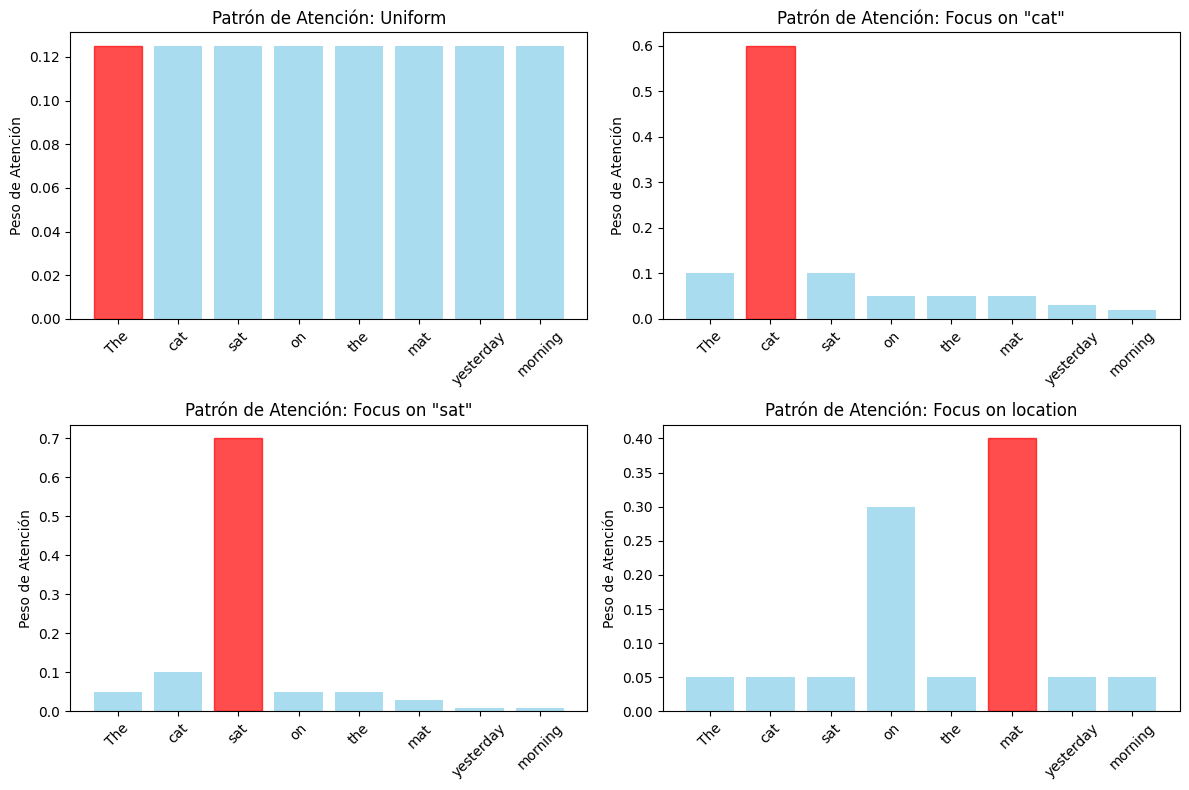

In [28]:
# CELDA 9: VISUALIZACIÓN DEL CONCEPTO DE ATENCIÓN
# =============================================================================

def visualize_attention_concept():
    """Visualiza el concepto de atención de manera simple"""
    # Simulamos atención en una secuencia
    seq_len = 8
    sentence = ["The", "cat", "sat", "on", "the", "mat", "yesterday", "morning"]

    # Simulamos diferentes patrones de atención
    attention_patterns = {
        'Uniform': np.ones(seq_len) / seq_len,
        'Focus on "cat"': np.array([0.1, 0.6, 0.1, 0.05, 0.05, 0.05, 0.03, 0.02]),
        'Focus on "sat"': np.array([0.05, 0.1, 0.7, 0.05, 0.05, 0.03, 0.01, 0.01]),
        'Focus on location': np.array([0.05, 0.05, 0.05, 0.3, 0.05, 0.4, 0.05, 0.05])
    }

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    for i, (pattern_name, weights) in enumerate(attention_patterns.items()):
        ax = axes[i]
        bars = ax.bar(range(seq_len), weights, color='skyblue', alpha=0.7)
        ax.set_title(f'Patrón de Atención: {pattern_name}')
        ax.set_xticks(range(seq_len))
        ax.set_xticklabels(sentence, rotation=45)
        ax.set_ylabel('Peso de Atención')

        # Resaltar la palabra con mayor atención
        max_idx = np.argmax(weights)
        bars[max_idx].set_color('red')

    plt.tight_layout()
    plt.show()

print("Visualizando conceptos de atención...")
visualize_attention_concept()

In [29]:
# CELDA 10: CLASES ENCODER Y DECODER
# =============================================================================

print("="*50)
print("ENCODER-DECODER CON ATENCIÓN")
print("="*50)

class Encoder(layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.gru = layers.GRU(self.enc_units,
                              return_sequences=True,
                              return_state=True)

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

class Decoder(layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.gru = layers.GRU(self.dec_units,
                              return_sequences=True,
                              return_state=True)
        self.fc = layers.Dense(vocab_size)

        # Capa de atención
        self.attention = AttentionLayer(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output: (batch_size, max_length, hidden_size)
        # hidden: (batch_size, hidden_size)
        # x: (batch_size, 1)

        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)

        # Concatenar contexto con input
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x, initial_state=hidden)

        output = tf.reshape(output, (-1, output.shape[2]))

        x = self.fc(output)

        return x, state, attention_weights

print("Clases Encoder y Decoder definidas")


ENCODER-DECODER CON ATENCIÓN
Clases Encoder y Decoder definidas


In [30]:
# CELDA 11: CREAR Y PROBAR ENCODER-DECODER
# =============================================================================

# Crear modelo encoder-decoder
EMBEDDING_DIM = 64
UNITS = 128

encoder = Encoder(en_vocab_size, EMBEDDING_DIM, UNITS)
decoder = Decoder(es_vocab_size, EMBEDDING_DIM, UNITS)

print("Encoder-Decoder con Atención creado")
print(f"Encoder embedding dim: {EMBEDDING_DIM}")
print(f"Hidden units: {UNITS}")

# Demostración de flujo de datos
sample_batch = 2
sample_sequence = X_train[:sample_batch]
print(f"\nDemostración con batch de tamaño: {sample_batch}")
print(f"Forma de entrada: {sample_sequence.shape}")

# Forward pass del encoder
sample_hidden = tf.zeros((sample_batch, UNITS))
sample_enc_output, sample_enc_hidden = encoder(sample_sequence, sample_hidden)

print(f"Salida del encoder: {sample_enc_output.shape}")
print(f"Estado oculto del encoder: {sample_enc_hidden.shape}")

# Forward pass del decoder (un paso)
sample_dec_input = tf.expand_dims([es_word_to_idx['<START>']] * sample_batch, 1)
sample_dec_output, sample_dec_hidden, sample_attention_weights = decoder(
    sample_dec_input, sample_enc_hidden, sample_enc_output)

print(f"Salida del decoder: {sample_dec_output.shape}")
print(f"Pesos de atención: {sample_attention_weights.shape}")


Encoder-Decoder con Atención creado
Encoder embedding dim: 64
Hidden units: 128

Demostración con batch de tamaño: 2
Forma de entrada: (2, 10)
Salida del encoder: (2, 10, 128)
Estado oculto del encoder: (2, 128)
Salida del decoder: (2, 46)
Pesos de atención: (2, 10, 1)


In [31]:
# CELDA 12: FUNCIONES PARA TRANSFORMERS - SCALED DOT PRODUCT ATTENTION
# =============================================================================

print("="*50)
print("SELF-ATTENTION Y TRANSFORMERS")
print("="*50)

def scaled_dot_product_attention(q, k, v, mask=None):
    """Calcula la atención del producto punto escalado"""

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # Escalar matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # Añadir máscara si se proporciona
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # Softmax
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

print("Función scaled_dot_product_attention definida")


SELF-ATTENTION Y TRANSFORMERS
Función scaled_dot_product_attention definida


Clase MultiHeadAttention definida
Ejecutando demostración de self-attention...
Demostración de Self-Attention:
Entrada: (1, 4, 8)
Salida de atención: (1, 4, 8)
Pesos de atención: (1, 2, 4, 4)


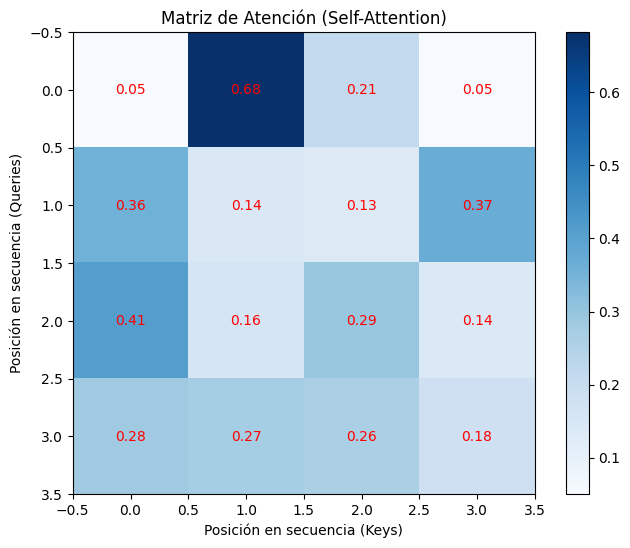

In [32]:
# CELDA 13: CLASE MULTI-HEAD ATTENTION
# =============================================================================

class MultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)

        self.dense = layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Divide la última dimensión en (num_heads, depth)"""
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)

        return output, attention_weights

print("Clase MultiHeadAttention definida")

# =============================================================================
# CELDA 14: DEMOSTRACIÓN DE SELF-ATTENTION
# =============================================================================

def demonstrate_self_attention():
    """Demuestra cómo funciona self-attention con un ejemplo simple"""

    # Crear datos de ejemplo
    batch_size = 1
    seq_len = 4
    d_model = 8

    # Simulamos embeddings de palabras
    sample_input = tf.random.normal((batch_size, seq_len, d_model))

    # Crear capa de multi-head attention
    mha = MultiHeadAttention(d_model=d_model, num_heads=2)

    # Aplicar self-attention (Q, K, V son la misma entrada)
    attention_output, attention_weights = mha(sample_input, sample_input, sample_input)

    print("Demostración de Self-Attention:")
    print(f"Entrada: {sample_input.shape}")
    print(f"Salida de atención: {attention_output.shape}")
    print(f"Pesos de atención: {attention_weights.shape}")

    # Visualizar matriz de atención
    # Promediamos sobre las cabezas para visualización
    avg_attention = tf.reduce_mean(attention_weights[0], axis=0)

    plt.figure(figsize=(8, 6))
    plt.imshow(avg_attention, cmap='Blues')
    plt.colorbar()
    plt.title('Matriz de Atención (Self-Attention)')
    plt.xlabel('Posición en secuencia (Keys)')
    plt.ylabel('Posición en secuencia (Queries)')

    # Añadir valores en cada celda
    for i in range(seq_len):
        for j in range(seq_len):
            plt.text(j, i, f'{avg_attention[i, j]:.2f}',
                    ha='center', va='center', color='red')

    plt.show()

    return attention_output, attention_weights

print("Ejecutando demostración de self-attention...")
demo_output, demo_weights = demonstrate_self_attention()

In [35]:
# CELDA 15: COMPARACIÓN CON TRANSFORMERS PRE-ENTRENADOS
# =============================================================================

print("="*50)
print("COMPARACIÓN CON TRANSFORMERS PRE-ENTRENADOS")
print("="*50)
from transformers import pipeline
import tensorflow as tf

try:
    translator = pipeline(
        "translation",
        model="Helsinki-NLP/opus-mt-en-es",
        device=0 if tf.config.list_physical_devices('GPU') else -1
    )

    # Probar con nuestros ejemplos
    test_sentences = ["hello world", "how are you", "good morning", "thank you"]

    print("\nComparación de traducciones:")
    print("-" * 60)
    print(f"{'Original':<15} | {'RNN Simple':<15} | {'Transformer':<15}")
    print("-" * 60)

    for sentence in test_sentences:
        # RNN simple
        rnn_trans = translate_simple(sentence, rnn_model, en_word_to_idx, es_idx_to_word)
        rnn_trans = rnn_trans.replace('<PAD>', '').strip()

        # Transformer pre-entrenado
        transformer_trans = translator(sentence)[0]['translation_text']

        print(f"{sentence:<15} | {rnn_trans:<15} | {transformer_trans:<15}")

except Exception as e:
    print(f"No se pudo cargar el modelo pre-entrenado: {e}")
    print("Ejecutando en modo sin comparación con Transformers...")

COMPARACIÓN CON TRANSFORMERS PRE-ENTRENADOS


Device set to use cpu



Comparación de traducciones:
------------------------------------------------------------
Original        | RNN Simple      | Transformer    
------------------------------------------------------------
hello world     | sin_traduccion  | Hola mundo     
how are you     | sin_traduccion  | ¿Cómo estás?   
good morning    | sin_traduccion  | Buenos días.   
thank you       | sin_traduccion  | Gracias.       


Generando comparación visual de arquitecturas...


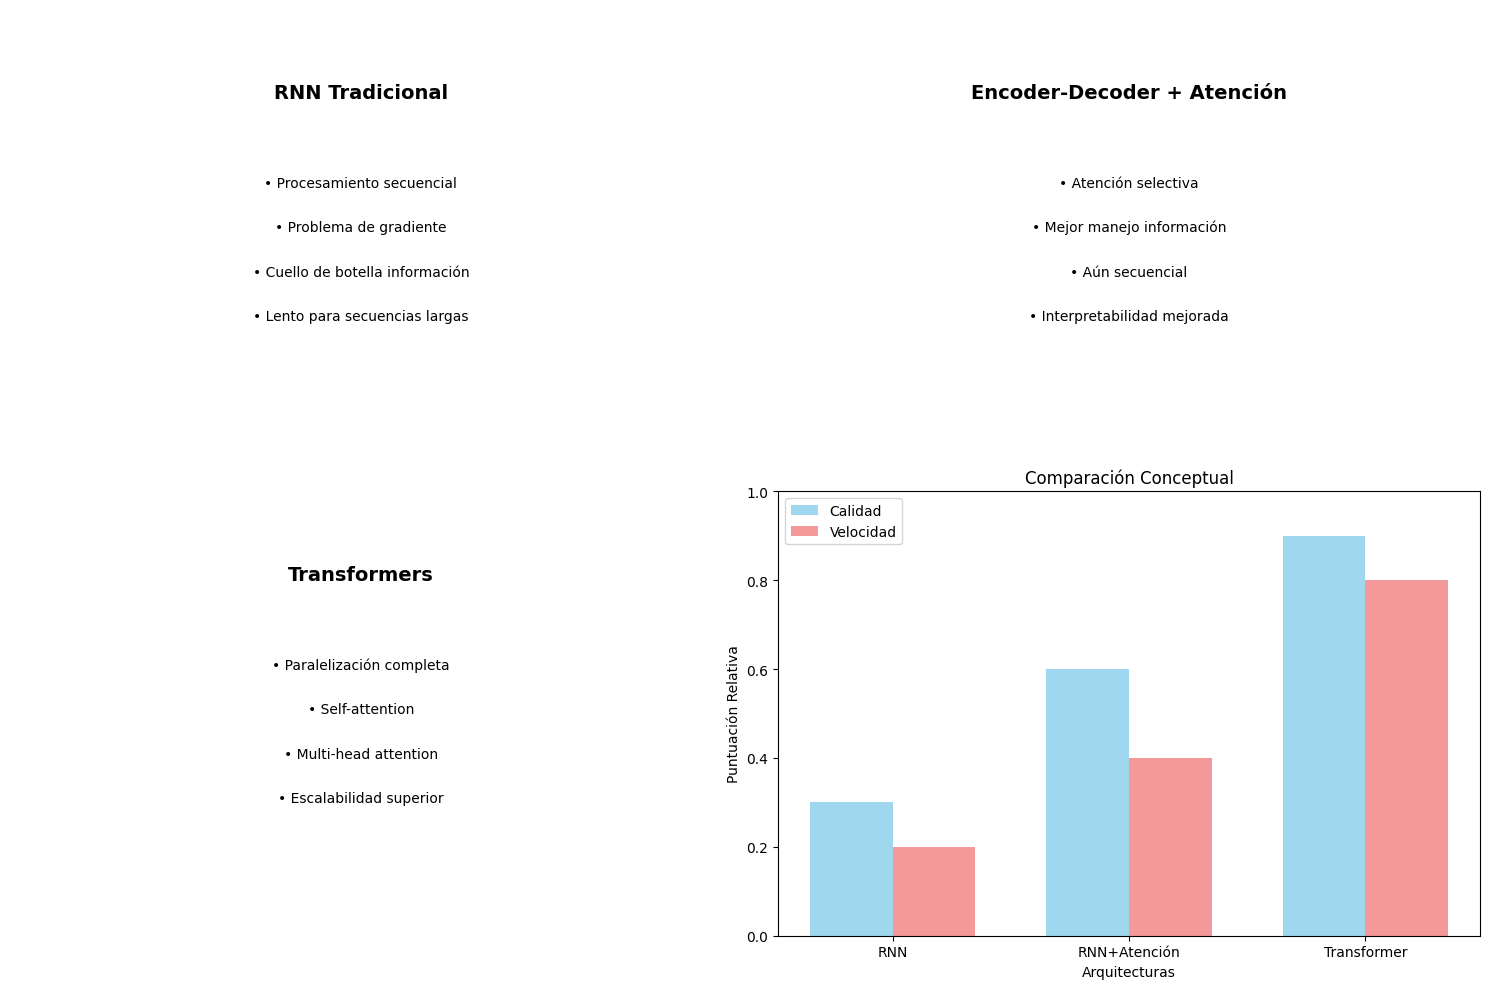

In [36]:
# CELDA 16: FUNCIÓN DE COMPARACIÓN VISUAL
# =============================================================================

def plot_training_comparison():
    """Compara las arquitecturas visualmente"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Arquitectura RNN
    ax1 = axes[0, 0]
    ax1.text(0.5, 0.8, 'RNN Tradicional', ha='center', fontsize=14, weight='bold')
    ax1.text(0.5, 0.6, '• Procesamiento secuencial', ha='center', fontsize=10)
    ax1.text(0.5, 0.5, '• Problema de gradiente', ha='center', fontsize=10)
    ax1.text(0.5, 0.4, '• Cuello de botella información', ha='center', fontsize=10)
    ax1.text(0.5, 0.3, '• Lento para secuencias largas', ha='center', fontsize=10)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.axis('off')

    # 2. Encoder-Decoder con Atención
    ax2 = axes[0, 1]
    ax2.text(0.5, 0.8, 'Encoder-Decoder + Atención', ha='center', fontsize=14, weight='bold')
    ax2.text(0.5, 0.6, '• Atención selectiva', ha='center', fontsize=10)
    ax2.text(0.5, 0.5, '• Mejor manejo información', ha='center', fontsize=10)
    ax2.text(0.5, 0.4, '• Aún secuencial', ha='center', fontsize=10)
    ax2.text(0.5, 0.3, '• Interpretabilidad mejorada', ha='center', fontsize=10)
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis('off')

    # 3. Transformers
    ax3 = axes[1, 0]
    ax3.text(0.5, 0.8, 'Transformers', ha='center', fontsize=14, weight='bold')
    ax3.text(0.5, 0.6, '• Paralelización completa', ha='center', fontsize=10)
    ax3.text(0.5, 0.5, '• Self-attention', ha='center', fontsize=10)
    ax3.text(0.5, 0.4, '• Multi-head attention', ha='center', fontsize=10)
    ax3.text(0.5, 0.3, '• Escalabilidad superior', ha='center', fontsize=10)
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)
    ax3.axis('off')

    # 4. Gráfico de rendimiento conceptual
    ax4 = axes[1, 1]
    models = ['RNN', 'RNN+Atención', 'Transformer']
    performance = [0.3, 0.6, 0.9]  # Valores conceptuales
    speed = [0.2, 0.4, 0.8]

    x = np.arange(len(models))
    width = 0.35

    ax4.bar(x - width/2, performance, width, label='Calidad', alpha=0.8, color='skyblue')
    ax4.bar(x + width/2, speed, width, label='Velocidad', alpha=0.8, color='lightcoral')

    ax4.set_xlabel('Arquitecturas')
    ax4.set_ylabel('Puntuación Relativa')
    ax4.set_title('Comparación Conceptual')
    ax4.set_xticks(x)
    ax4.set_xticklabels(models)
    ax4.legend()
    ax4.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

print("Generando comparación visual de arquitecturas...")
plot_training_comparison()
